In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import obspy.geodetics.flinnengdahl as flinnengdahl
fe = flinnengdahl.FlinnEngdahl()

import cmcrameri.cm as cmc

In [2]:
def myround(x, base=5):
    return base * round(x/base)

In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [4]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [5]:
def get_mag(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    mag = db['scardec_magnitude'].values[0]
    return mag

def get_date(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    year = db['year'].values[0]
    month = db['month'].values[0]
    day = db['day'].values[0]
    return year, month, day

In [6]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [7]:
def bootstrap(data, n=1000, proportion = 1):
    """Bootstrap resampling of data.

    Args:
        data: 1D array of data to be resampled.
        n: number of resamples to take.

    Returns:
        resampled data.
    """

    rng = np.random.default_rng()

    resampled_data = rng.choice(data, (n, int(len(data)*proportion)), replace = True)

    return resampled_data

In [8]:
def convert_fe_subdivisions_to_regions(subdivision):
    final_values = [17, 29, 46, 52, 71, 83, 101, 142, 146, 157, 168, 179, 182, 189,
                    195, 208, 210, 216, 230, 241, 247, 260, 272, 293, 301, 319, 325,
                    334, 356, 375, 401, 414, 437, 527, 531, 549, 587, 610, 632, 655,
                    666, 682, 692, 699, 702, 708, 712, 720, 726, 729]

    if subdivision < 730:
        for index, max_value in enumerate(final_values):
            if subdivision <= max_value:
                return index+1
    else:
        if subdivision == 730:
            return 5
        elif subdivision == 731:
            return 7
        elif subdivision == 732:
            return 10
        elif subdivision in [733, 734, 735, 736, 737]:
            return 25
        elif subdivision in [738, 739]:
            return 32
        elif subdivision in [740, 741, 742]:
            return 33
        elif subdivision in [743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755]:
            return 37
        elif subdivision == 756:
            return 43
        elif subdivision == 757:
            return 44
        else:
            return None


In [101]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day', 'latitude', 'longitude', 'depth', 'FE', 'region', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

import seaborn as sns


sns.set_theme(style="ticks", context="poster",rc={'figure.figsize':(20,20), "font.size":36})


params = {"ytick.color" : "w",
        "xtick.color" : "w",
        "axes.labelcolor" : "w",
        "axes.edgecolor" : "w"}
plt.rcParams.update(params)

count = 0

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)
    print(count)
    db = combined[combined['scardec_name']==scardec_name]
    momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type = 'fctmoy')

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])

    relative_root_times = []
    root_times = []
    for proportion in proportions_list:
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))

        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        root_times.append(root_time)
        relative_root_times.append((root_time-start_time)/duration)
    mags = get_mag(scardec_name)
    int_mags = int(mags)

    fe_region = fe.get_number(db['longitude'].values[0], db['latitude'].values[0])

    region = convert_fe_subdivisions_to_regions(fe_region)

    list_for_database = [scardec_name, mags, int_mags, *get_date(scardec_name), db['latitude'].values[0], db['longitude'].values[0], db['depth'].values[0], fe_region, region, *relative_root_times]
    results_db.loc[len(results_db)] = list_for_database
    try:
        fig, ax = plt.subplots(figsize=(20, 10))
        root_times.append(time_opt[end])

        momentrate_opt = np.array(momentrate_opt)
        time_opt = np.array(time_opt)

        ax.fill_between(time_opt, momentrate_opt/1e19,
                            color = 'white',
                            alpha = 1,
                            label='Shaded Area')

        for i in range(0, len(root_times)):
            #print(i)
            if i == 0:
                ax.fill_between(time_opt, momentrate_opt/1e19, where=(time_opt >= start_time) & (time_opt <= root_times[i]),
                                color = cmc.hawaii(i/(len(root_times)-1)),
                                alpha = 0.35,
                                label='Shaded Area')
            else:
                ax.fill_between(time_opt, momentrate_opt/1e19, where=(time_opt >= root_times[i-1]) & (time_opt <= root_times[i]),
                                color = cmc.hawaii(i/(len(root_times)-1)),
                                alpha = 0.35,
                                label='Shaded Area')
                ax.axvline(x = root_times[i-1],
                            ymax=(momentrate_opt[np.where(time_opt == root_times[i-1])][0]/(momentrate_opt.max()*1.1)),
                            color = cmc.hawaii(i/(len(root_times)-1)),
                            alpha = 1)

        ax.set_ylim(0, momentrate_opt.max()*1.1/1e19)

        ax.plot(time_opt, momentrate_opt/1e19, color = 'white')

        ax.set_ylabel(r'Moment Rate ($\times 10^{19}$ Nm/s)')
        ax.set_xlabel('Time (s)')
        sns.despine()
        plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/intro_figure_white/{count}.png', dpi = 300, transparent=True)
        plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/intro_figure_white/{count}.svg')
        plt.close()
    except Exception:
        print('Failed')
        plt.close()
        pass
    count += 1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
Failed
24
25
26
27
28
29
Failed
30
Failed
31
Failed
32
33
34
35
36
37
38
39
Failed
40
41
42
43
44
Failed
45
Failed
46
47
48
49
50
Failed
51
52
53
54
55
56
57
Failed
58
Failed
59
60
61
62
63
Failed
64
Failed
65
66
Failed
67
68
69
70
71
Failed
72
Failed
73
74
75
76
Failed
77
78
79
Failed
80
81
82
83
84
85
86
87
Failed
88
89
90
Failed
91
92
93
94
95
96
97
98
99
Failed
100
101
Failed
102
103
104
105
Failed
106
107
108
109
110
Failed
111
Failed
112
113
114
115
Failed
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
Failed
132
133
134
135
136
137
138
139
140
Failed
141
142
Failed
143
144
Failed
145
Failed
146
147
148
Failed
149
Failed
150
151
152
Failed
153
154
Failed
155
156
157
158
Failed
159
160
161
162
163
164
165
166
Failed
167
Failed
168
Failed
169
170
171
172
173
174
Failed
175
176
Failed
177
178
179
180
181
182
183
184
185
186
187
Failed
188
189
190
191
192
193
194
195
196
197
198
199
200
Failed
201
Failed
2

In [106]:
results_10.iloc[459]

scardec_name     FCTs_20170808_131949_GANSU__CHINA
magnitude                                    6.516
int_magnitude                                    6
year                                          2017
month                                            8
day                                              8
region                                          27
0_10                                      0.206573
10_20                                     0.051643
20_30                                     0.037559
30_40                                     0.042254
40_50                                     0.046948
50_60                                     0.056338
60_70                                     0.075117
70_80                                     0.112676
80_90                                     0.098592
90_100                                      0.2723
Name: 459, dtype: object

In [105]:
results_10 = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year' ,'month', 'day', 'region', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

results_10['scardec_name'] = results_db['scardec_name']
results_10['magnitude'] = results_db['magnitude']
results_10['int_magnitude'] = results_db['int_magnitude']
results_10['year'] = results_db['year']
results_10['month'] = results_db['month']
results_10['day'] = results_db['day']
results_10['region'] = results_db['region']

results_10['0_10'] = results_db['10']
results_10['10_20'] = results_db['20'] - results_db['10']
results_10['20_30'] = results_db['30'] - results_db['20']
results_10['30_40'] = results_db['40'] - results_db['30']
results_10['40_50'] = results_db['50'] - results_db['40']
results_10['50_60'] = results_db['60'] - results_db['50']
results_10['60_70'] = results_db['70'] - results_db['60']
results_10['70_80'] = results_db['80'] - results_db['70']
results_10['80_90'] = results_db['90'] - results_db['80']
results_10['90_100'] = 1 - results_db['90']


In [97]:
momentrate_opt = np.array(momentrate_opt)
time_opt = np.array(time_opt)

In [98]:
root_times.append(time_opt[end])

0


TypeError: '>=' not supported between instances of 'list' and 'float'

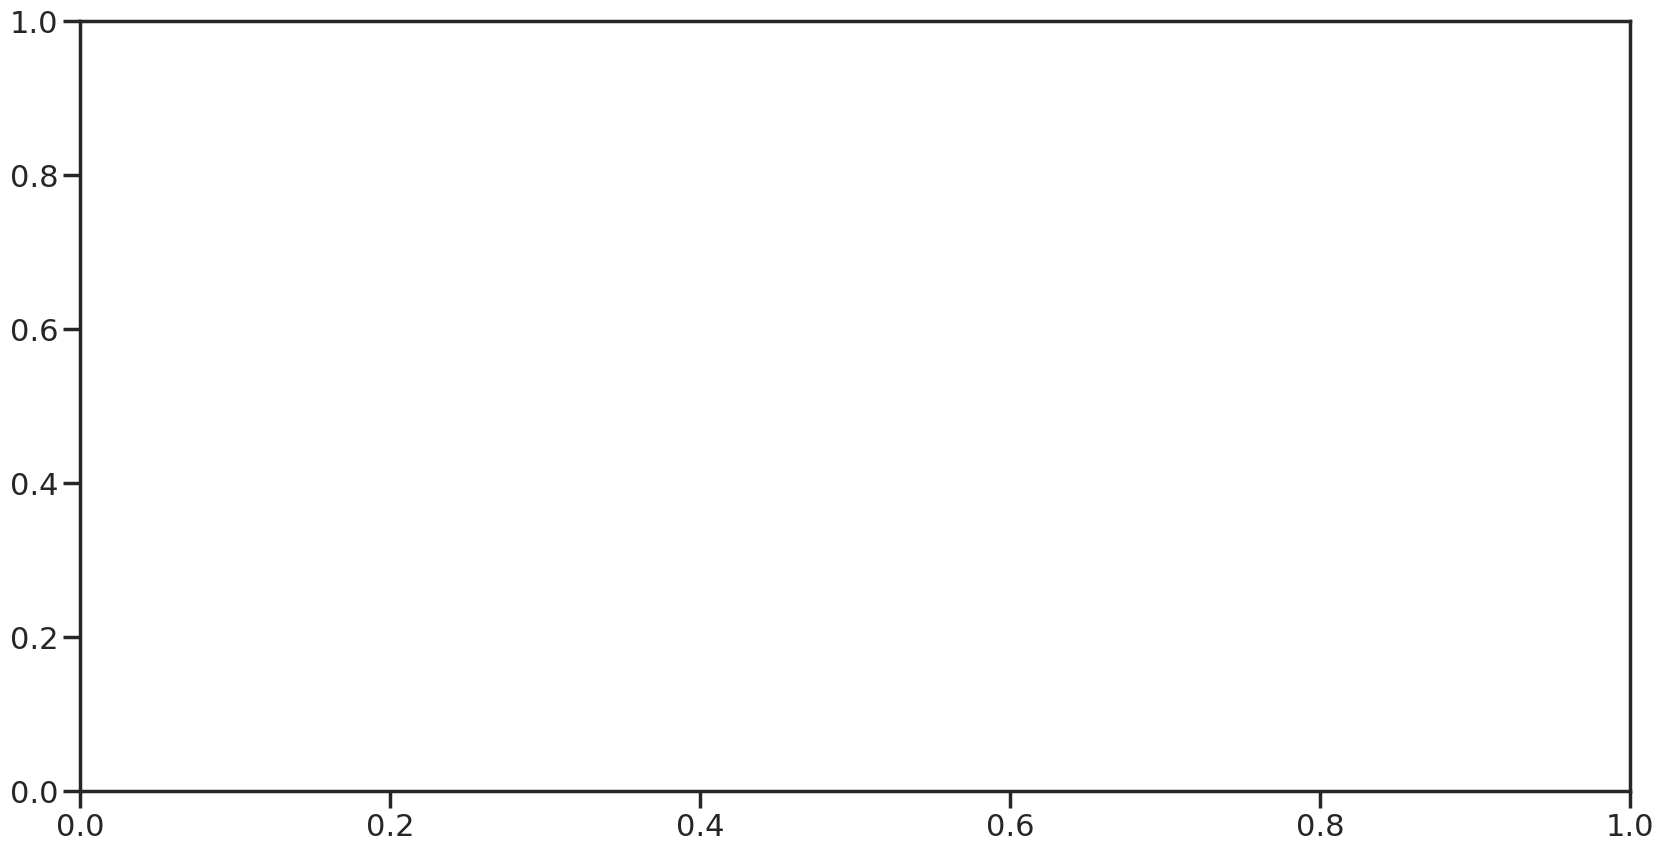

In [95]:
import seaborn as sns
sns.set(style="ticks", context="poster")

fig, ax = plt.subplots(figsize=(20, 10))

for i in range(0, len(root_times)):
    print(i)
    if i == 0:
        ax.fill_between(time_opt, momentrate_opt/1e19, where=(time_opt >= start_time) & (time_opt <= root_times[i]),
                         color = cmc.hawaii(i/(len(root_times)-1)),
                         alpha = 0.2,
                         label='Shaded Area')
    else:
        ax.fill_between(time_opt, momentrate_opt/1e19, where=(time_opt >= root_times[i-1]) & (time_opt <= root_times[i]),
                         color = cmc.hawaii(i/(len(root_times)-1)),
                         alpha = 0.2,
                         label='Shaded Area')
        ax.axvline(x = root_times[i-1],
                    ymax=(momentrate_opt[np.where(time_opt == root_times[i-1])][0]/(momentrate_opt.max()*1.1)),
                    color = cmc.hawaii(i/(len(root_times)-1)),
                    alpha = 1)

ax.set_ylim(0, momentrate_opt.max()*1.1/1e19)

ax.plot(time_opt, momentrate_opt/1e19, color = 'k')
ax.set_ylabel(r'Moment Rate ($\times 10^{19}$ Nm/s)')
ax.set_xlabel('Time (s)')
sns.despine()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/intro_figure_2.png', dpi = 300)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/intro_figure_2.svg')

0
1
2
3
4
5
6
7
8
9
10


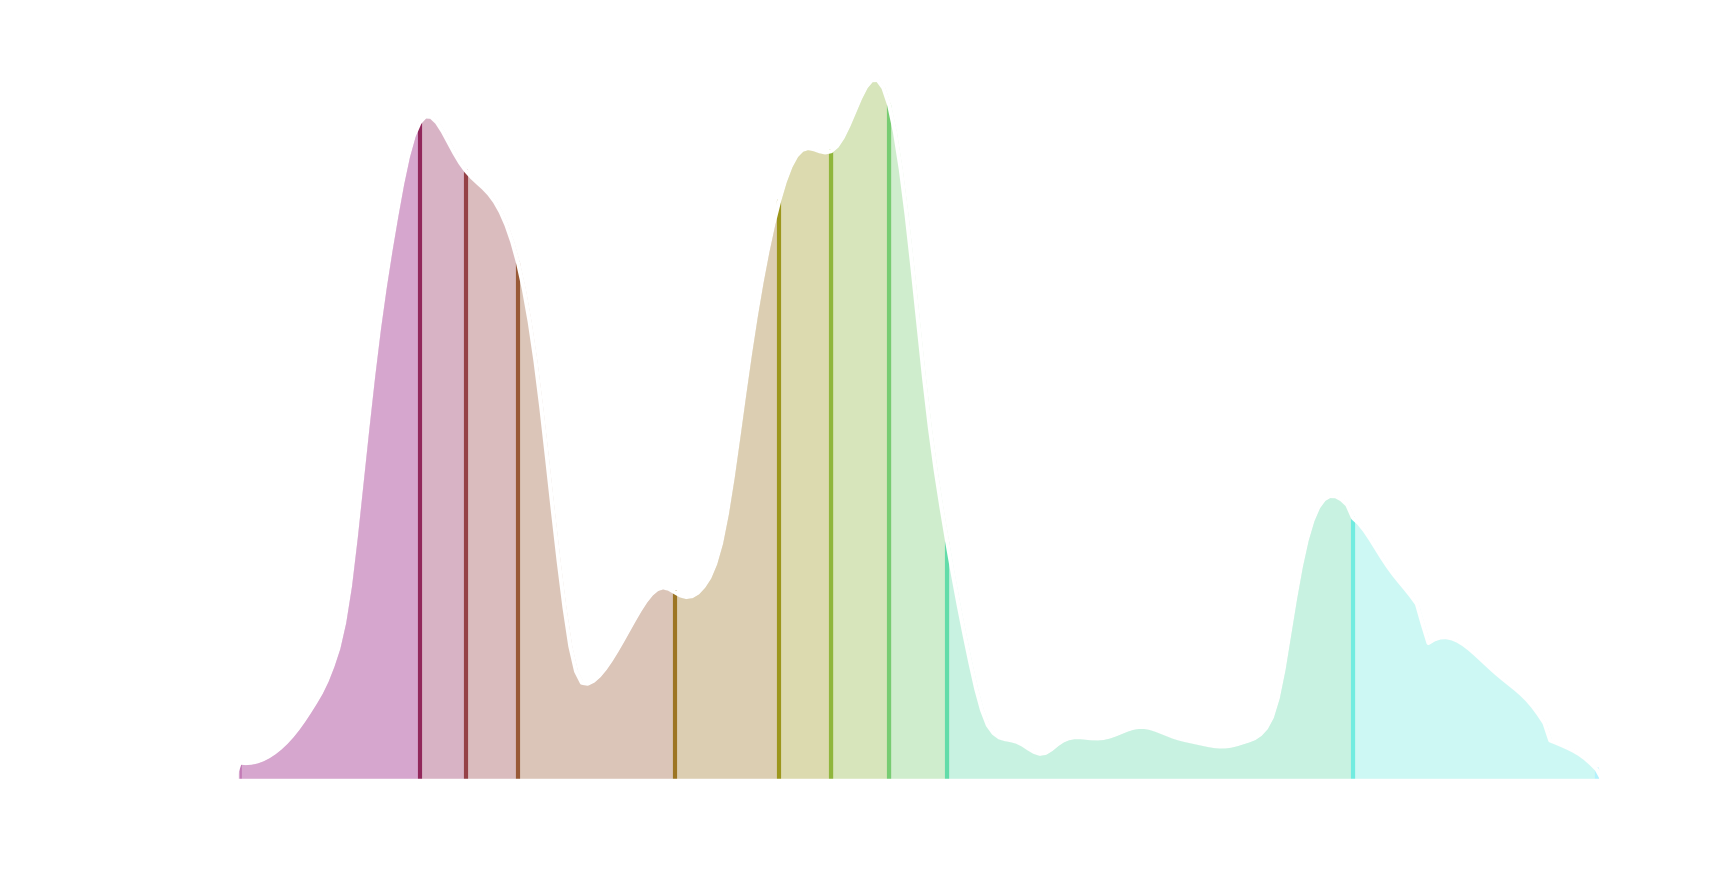

In [99]:
import seaborn as sns


sns.set_theme(style="ticks", context="poster",rc={'figure.figsize':(20,20), "font.size":36})


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


fig, ax = plt.subplots(figsize=(20, 10))

ax.fill_between(time_opt, momentrate_opt/1e19,
                    color = 'white',
                    alpha = 1,
                    label='Shaded Area')

for i in range(0, len(root_times)):
    print(i)
    if i == 0:
        ax.fill_between(time_opt, momentrate_opt/1e19, where=(time_opt >= start_time) & (time_opt <= root_times[i]),
                         color = cmc.hawaii(i/(len(root_times)-1)),
                         alpha = 0.35,
                         label='Shaded Area')
    else:
        ax.fill_between(time_opt, momentrate_opt/1e19, where=(time_opt >= root_times[i-1]) & (time_opt <= root_times[i]),
                         color = cmc.hawaii(i/(len(root_times)-1)),
                         alpha = 0.35,
                         label='Shaded Area')
        ax.axvline(x = root_times[i-1],
                    ymax=(momentrate_opt[np.where(time_opt == root_times[i-1])][0]/(momentrate_opt.max()*1.1)),
                    color = cmc.hawaii(i/(len(root_times)-1)),
                    alpha = 1)

ax.set_ylim(0, momentrate_opt.max()*1.1/1e19)

ax.plot(time_opt, momentrate_opt/1e19, color = 'white')



ax.set_ylabel(r'Moment Rate ($\times 10^{19}$ Nm/s)')
ax.set_xlabel('Time (s)')
sns.despine()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/intro_figure_white_2.png', dpi = 300, transparent=True)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/intro_figure_white_2.svg')